# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use Score/Rating. A rating of 4 or 5 can be cosnidered as a positive review. A rating of 1 or 2 can be considered as negative one. A review of rating 3 is considered nuetral and such reviews are ignored from our analysis. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




# [1]. Reading Data

## [1.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it is easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score is above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [4]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, roc_auc_score
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from collections import Counter
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_validate



In [5]:
# using SQLite Table to read data.
con = sqlite3.connect('/Users/puravshah/Downloads/amazon-fine-food-reviews/database.sqlite') 

# filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
# SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000, will give top 500000 data points
# you can change the number to any other number based on your computing power

# filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000""", con) 
# for tsne assignment you can take 5k data points

filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 40000""", con) 

# Give reviews with Score>3 a positive rating(1), and reviews with a score<3 a negative rating(0).
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (40000, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [6]:
display = pd.read_sql_query("""
SELECT UserId, ProductId, ProfileName, Time, Score, Text, COUNT(*)
FROM Reviews
GROUP BY UserId
HAVING COUNT(*)>1
""", con)

In [7]:
print(display.shape)
display.head()

(80668, 7)


,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
0,#oc-R115TNMSPFT9I7,B007Y59HVM,Breyton,1331510400,2,Overall its just OK when considering the price...,2
1,#oc-R11D9D7SHXIJB9,B005HG9ET0,"Louis E. Emory ""hoppy""",1342396800,5,"My wife has recurring extreme muscle spasms, u...",3
2,#oc-R11DNU2NBKQ23Z,B007Y59HVM,Kim Cieszykowski,1348531200,1,This coffee is horrible and unfortunately not ...,2
3,#oc-R11O5J5ZVQE25C,B005HG9ET0,Penguin Chick,1346889600,5,This will be the bottle that you grab from the...,3
4,#oc-R12KPBODL2B5ZD,B007OSBE1U,Christopher P. Presta,1348617600,1,I didnt like this coffee. Instead of telling y...,2


In [8]:
display[display['UserId']=='AZY10LLTJ71NX']

,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
80638,AZY10LLTJ71NX,B006P7E5ZI,"undertheshrine ""undertheshrine""",1334707200,5,I was recommended to try green tea extract to ...,5


In [9]:
display['COUNT(*)'].sum()

393063

#  [2] Exploratory Data Analysis

## [2.1] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [10]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


As it can be seen above that same user has multiple reviews with same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [11]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [12]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(37415, 10)

In [13]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

93.5375

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [14]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [15]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [16]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(37415, 10)


1    31324
0     6091
Name: Score, dtype: int64

#  [3] Preprocessing

## [3.1].  Preprocessing Review Text

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [17]:
# printing some random reviews
sent_0 = final['Text'].values[0]
print(sent_0)
print("="*50)

sent_1000 = final['Text'].values[1000]
print(sent_1000)
print("="*50)

sent_1500 = final['Text'].values[1500]
print(sent_1500)
print("="*50)

sent_4900 = final['Text'].values[4900]
print(sent_4900)
print("="*50)

Our dogs just love them.  I saw them in a pet store and a tag was attached regarding them being made in China and it satisfied me that they were safe.
It's Branston pickle, what is there to say. If you've never tried it you most likely wont like it. If you grew up in the UK its a staple on cheese of cold meat sandwiches. It's on my lunch sandwich today! :)
First Impression: The friendly folks over at "Exclusively Dog" heard about my website and sent me 5 of their products to test.<br />Let me just start off by saying that I Love how sweet all of these treats taste. Dad was/is considering trying one because they look and smell so much like human cookies. Plus the ingredients are very straight forward, they are probably healthier than most the stuff Mom eats... But there in lies the problem. Dad thinks that they are too sweet for a puppy of any age. The second ingredient in almost all of them is sugar. As we all know puppies have a hard time processing sugar, and just like humans can dev

In [18]:
# remove urls from text python: https://stackoverflow.com/a/40823105/4084039
sent_0 = re.sub(r"http\S+", "", sent_0)
sent_1000 = re.sub(r"http\S+", "", sent_1000)
sent_150 = re.sub(r"http\S+", "", sent_1500)
sent_4900 = re.sub(r"http\S+", "", sent_4900)

print(sent_0)

Our dogs just love them.  I saw them in a pet store and a tag was attached regarding them being made in China and it satisfied me that they were safe.


In [19]:
# https://stackoverflow.com/questions/16206380/python-beautifulsoup-how-to-remove-all-tags-from-an-element
from bs4 import BeautifulSoup

soup = BeautifulSoup(sent_0, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1000, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1500, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_4900, 'lxml')
text = soup.get_text()
print(text)

Our dogs just love them.  I saw them in a pet store and a tag was attached regarding them being made in China and it satisfied me that they were safe.
It's Branston pickle, what is there to say. If you've never tried it you most likely wont like it. If you grew up in the UK its a staple on cheese of cold meat sandwiches. It's on my lunch sandwich today! :)
First Impression: The friendly folks over at "Exclusively Dog" heard about my website and sent me 5 of their products to test.Let me just start off by saying that I Love how sweet all of these treats taste. Dad was/is considering trying one because they look and smell so much like human cookies. Plus the ingredients are very straight forward, they are probably healthier than most the stuff Mom eats... But there in lies the problem. Dad thinks that they are too sweet for a puppy of any age. The second ingredient in almost all of them is sugar. As we all know puppies have a hard time processing sugar, and just like humans can develop d

In [20]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [21]:
sent_1500 = decontracted(sent_1500)
print(sent_1500)
print("="*50)

First Impression: The friendly folks over at "Exclusively Dog" heard about my website and sent me 5 of their products to test.<br />Let me just start off by saying that I Love how sweet all of these treats taste. Dad was/is considering trying one because they look and smell so much like human cookies. Plus the ingredients are very straight forward, they are probably healthier than most the stuff Mom eats... But there in lies the problem. Dad thinks that they are too sweet for a puppy of any age. The second ingredient in almost all of them is sugar. As we all know puppies have a hard time processing sugar, and just like humans can develop diabetes.<br /><br />Conclusion: Your puppy is nearly guaranteed to LOVE the taste. However these should only be used as an occasional treat! If you were to feed your puppies these sugary sweet morsels every day, they would soon plump up. If you puppy is already overweight or does not exercise regularly, you may want to think twice. On the PRO side the

In [22]:
#remove words with numbers python: https://stackoverflow.com/a/18082370/4084039
sent_0 = re.sub("\S*\d\S*", "", sent_0).strip()
print(sent_0)

Our dogs just love them.  I saw them in a pet store and a tag was attached regarding them being made in China and it satisfied me that they were safe.


In [23]:
#remove spacial character: https://stackoverflow.com/a/5843547/4084039
sent_1500 = re.sub('[^A-Za-z0-9]+', ' ', sent_1500)
print(sent_1500)

First Impression The friendly folks over at Exclusively Dog heard about my website and sent me 5 of their products to test br Let me just start off by saying that I Love how sweet all of these treats taste Dad was is considering trying one because they look and smell so much like human cookies Plus the ingredients are very straight forward they are probably healthier than most the stuff Mom eats But there in lies the problem Dad thinks that they are too sweet for a puppy of any age The second ingredient in almost all of them is sugar As we all know puppies have a hard time processing sugar and just like humans can develop diabetes br br Conclusion Your puppy is nearly guaranteed to LOVE the taste However these should only be used as an occasional treat If you were to feed your puppies these sugary sweet morsels every day they would soon plump up If you puppy is already overweight or does not exercise regularly you may want to think twice On the PRO side they are all natural with no ani

In [24]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [25]:
# Combining all the above stundents 
from tqdm import tqdm
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())

100%|██████████| 37415/37415 [00:11<00:00, 3267.77it/s]


In [26]:
preprocessed_reviews[1500]

'first impression friendly folks exclusively dog heard website sent products test let start saying love sweet treats taste dad considering trying one look smell much like human cookies plus ingredients straight forward probably healthier stuff mom eats lies problem dad thinks sweet puppy age second ingredient almost sugar know puppies hard time processing sugar like humans develop diabetes conclusion puppy nearly guaranteed love taste however used occasional treat feed puppies sugary sweet morsels every day would soon plump puppy already overweight not exercise regularly may want think twice pro side natural no animal bi products paws dad made judging taste alone would'

<h2><font color='red'>[3.2] Preprocessing Review Summary</font></h2>

In [27]:
## Similartly you can do preprocessing for review summary also.

# [4] Featurization

## [4.1] BAG OF WORDS

In [28]:
#BoW
from sklearn.preprocessing import StandardScaler
scaler=StandardScaler(with_mean=False)
X_1, X_test, y_1, y_test = train_test_split(preprocessed_reviews, final['Score'], test_size=0.3, random_state=0)
X_tr, X_cv, y_tr, y_cv =train_test_split(X_1, y_1, test_size=0.3)
count_vect = CountVectorizer() #in scikit-learn
count_vect.fit(X_tr)

print("some feature names ", count_vect.get_feature_names()[:10])
print('='*50)

final_counts = count_vect.transform(X_tr)
final_counts=scaler.fit_transform(final_counts)
X_cv_bow=count_vect.transform(X_cv)
X_cv_bow=scaler.transform(X_cv_bow)
X_test_bow=count_vect.transform(X_test)
X_test_bow=scaler.transform(X_test_bow)
print("the type of count vectorizer ",type(final_counts))
print("the shape of out text BOW vectorizer ",final_counts.get_shape())
print("the number of unique words ", final_counts.get_shape()[1])
print(y_test.shape)

some feature names  ['aa', 'aaaa', 'aaaaa', 'aaaaaaaaaaaaaaa', 'aachen', 'aadp', 'aafco', 'aahs', 'aarthur', 'ab']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (18333, 25298)
the number of unique words  25298
(11225,)


## [4.2] Bi-Grams and n-Grams.

In [29]:
#bi-gram, tri-gram and n-gram

#removing stop words like "not" should be avoided before building n-grams
# count_vect = CountVectorizer(ngram_range=(1,2))
# please do read the CountVectorizer documentation http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html

count_vect_gram = CountVectorizer(ngram_range=(1,2), min_df=10, max_features=5000)
count_vect_gram.fit(X_tr)
final_bigram_counts = count_vect_gram.transform(X_tr)
final_bigram_counts=scaler.fit_transform(final_bigram_counts)
X_cv_ngram = count_vect_gram.transform(X_cv)
X_cv_ngram=scaler.transform(X_cv_ngram)
X_test_ngram=count_vect_gram.transform(X_test)
X_test_ngram=scaler.transform(X_test_ngram)
print("the type of count vectorizer ",type(final_bigram_counts))
print("the shape of out text BOW vectorizer ",final_bigram_counts.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_bigram_counts.get_shape()[1])

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (18333, 5000)
the number of unique words including both unigrams and bigrams  5000


## [4.3] TF-IDF

In [30]:
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2), min_df=10)
tf_idf_vect.fit(X_tr)

print("some sample features(unique words in the corpus)",tf_idf_vect.get_feature_names()[0:10])
print('='*50)

final_tf_idf = tf_idf_vect.transform(X_tr)
final_tf_idf=scaler.fit_transform(final_tf_idf)
X_cv_tfidf=tf_idf_vect.transform(X_cv)
X_cv_tfidf=scaler.transform(X_cv_tfidf)
X_test_tfidf=tf_idf_vect.transform(X_test)
X_test_tfidf=scaler.transform(X_test_tfidf)
print("the type of count vectorizer ",type(final_tf_idf))
print("the shape of out text TFIDF vectorizer ",final_tf_idf.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_tf_idf.get_shape()[1])

some sample features(unique words in the corpus) ['ability', 'able', 'able buy', 'able drink', 'able eat', 'able enjoy', 'able find', 'able get', 'able give', 'able make']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text TFIDF vectorizer  (18333, 11013)
the number of unique words including both unigrams and bigrams  11013


## [4.4] Word2Vec

In [31]:
i=0
list_of_sentance_train=[]
for sentance in X_tr:
    list_of_sentance_train.append(sentance.split())

In [32]:
i=0
list_of_sentance_cv=[]
for sentance in X_cv:
    list_of_sentance_cv.append(sentance.split())

In [33]:
i=0
list_of_sentance_test=[]
for sentance in X_test:
    list_of_sentance_test.append(sentance.split())

In [34]:
# Using Google News Word2Vectors

# in this project we are using a pretrained model by google
# its 3.3G file, once you load this into your memory 
# it occupies ~9Gb, so please do this step only if you have >12G of ram
# we will provide a pickle file wich contains a dict , 
# and it contains all our courpus words as keys and  model[word] as values
# To use this code-snippet, download "GoogleNews-vectors-negative300.bin" 
# from https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit
# it's 1.9GB in size.


# http://kavita-ganesan.com/gensim-word2vec-tutorial-starter-code/#.W17SRFAzZPY
# you can comment this whole cell
# or change these varible according to your need

is_your_ram_gt_16g=False
want_to_use_google_w2v = False
want_to_train_w2v = True

if want_to_train_w2v:
    # min_count = 5 considers only words that occured atleast 5 times
    w2v_model_train=Word2Vec(list_of_sentance_train,min_count=5,size=50, workers=4)
    print(w2v_model_train.wv.most_similar('great'))
    print('='*50)
    print(w2v_model_train.wv.most_similar('worst'))
    
elif want_to_use_google_w2v and is_your_ram_gt_16g:
    if os.path.isfile('GoogleNews-vectors-negative300.bin'):
        w2v_model=KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)
        print(w2v_model.wv.most_similar('great'))
        print(w2v_model.wv.most_similar('worst'))
    else:
        print("you don't have gogole's word2vec file, keep want_to_train_w2v = True, to train your own w2v ")

[('awesome', 0.8241584897041321), ('good', 0.8196554780006409), ('excellent', 0.8115324378013611), ('fantastic', 0.8062401413917542), ('wonderful', 0.7809844613075256), ('amazing', 0.7776182293891907), ('perfect', 0.7070127129554749), ('decent', 0.6891011595726013), ('delicious', 0.6866593360900879), ('love', 0.6519224643707275)]
[('hooked', 0.8284764289855957), ('closest', 0.8278428912162781), ('hottest', 0.8239474892616272), ('experienced', 0.818336009979248), ('ive', 0.8117782473564148), ('hated', 0.8094334602355957), ('kicking', 0.7950804829597473), ('tastiest', 0.7943421006202698), ('hands', 0.792421281337738), ('nastiest', 0.7879497408866882)]


In [35]:
''''is_your_ram_gt_16g=False
want_to_use_google_w2v = False
want_to_train_w2v = True

if want_to_train_w2v:
    # min_count = 5 considers only words that occured atleast 5 times
    w2v_model_cv=Word2Vec(list_of_sentance_cv,min_count=5,size=50, workers=4)
    print(w2v_model_cv.wv.most_similar('great'))
    print('='*50)
    print(w2v_model_cv.wv.most_similar('worst'))
    
elif want_to_use_google_w2v and is_your_ram_gt_16g:
    if os.path.isfile('GoogleNews-vectors-negative300.bin'):
        w2v_model=KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)
        print(w2v_model.wv.most_similar('great'))
        print(w2v_model.wv.most_similar('worst'))
    else:
        print("you don't have gogole's word2vec file, keep want_to_train_w2v = True, to train your own w2v ")'''

'\'is_your_ram_gt_16g=False\nwant_to_use_google_w2v = False\nwant_to_train_w2v = True\n\nif want_to_train_w2v:\n    # min_count = 5 considers only words that occured atleast 5 times\n    w2v_model_cv=Word2Vec(list_of_sentance_cv,min_count=5,size=50, workers=4)\n    print(w2v_model_cv.wv.most_similar(\'great\'))\n    print(\'=\'*50)\n    print(w2v_model_cv.wv.most_similar(\'worst\'))\n    \nelif want_to_use_google_w2v and is_your_ram_gt_16g:\n    if os.path.isfile(\'GoogleNews-vectors-negative300.bin\'):\n        w2v_model=KeyedVectors.load_word2vec_format(\'GoogleNews-vectors-negative300.bin\', binary=True)\n        print(w2v_model.wv.most_similar(\'great\'))\n        print(w2v_model.wv.most_similar(\'worst\'))\n    else:\n        print("you don\'t have gogole\'s word2vec file, keep want_to_train_w2v = True, to train your own w2v ")'

In [36]:
''''is_your_ram_gt_16g=False
want_to_use_google_w2v = False
want_to_train_w2v = True

if want_to_train_w2v:
    # min_count = 5 considers only words that occured atleast 5 times
    w2v_model_test=Word2Vec(list_of_sentance_test,min_count=5,size=50, workers=4)
    print(w2v_model_test.wv.most_similar('great'))
    print('='*50)
    print(w2v_model_test.wv.most_similar('worst'))
    
elif want_to_use_google_w2v and is_your_ram_gt_16g:
    if os.path.isfile('GoogleNews-vectors-negative300.bin'):
        w2v_model=KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)
        print(w2v_model.wv.most_similar('great'))
        print(w2v_model.wv.most_similar('worst'))
    else:
        print("you don't have gogole's word2vec file, keep want_to_train_w2v = True, to train your own w2v ")'''

'\'is_your_ram_gt_16g=False\nwant_to_use_google_w2v = False\nwant_to_train_w2v = True\n\nif want_to_train_w2v:\n    # min_count = 5 considers only words that occured atleast 5 times\n    w2v_model_test=Word2Vec(list_of_sentance_test,min_count=5,size=50, workers=4)\n    print(w2v_model_test.wv.most_similar(\'great\'))\n    print(\'=\'*50)\n    print(w2v_model_test.wv.most_similar(\'worst\'))\n    \nelif want_to_use_google_w2v and is_your_ram_gt_16g:\n    if os.path.isfile(\'GoogleNews-vectors-negative300.bin\'):\n        w2v_model=KeyedVectors.load_word2vec_format(\'GoogleNews-vectors-negative300.bin\', binary=True)\n        print(w2v_model.wv.most_similar(\'great\'))\n        print(w2v_model.wv.most_similar(\'worst\'))\n    else:\n        print("you don\'t have gogole\'s word2vec file, keep want_to_train_w2v = True, to train your own w2v ")'

In [37]:
w2v_words_train = list(w2v_model_train.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words_train))
print("sample words ", w2v_words_train[0:50])

number of words that occured minimum 5 times  8207
sample words  ['purchased', 'product', 'name', 'rumford', 'naturals', 'corn', 'starch', 'word', 'appears', 'large', 'clear', 'pictured', 'label', 'also', 'amazon', 'description', 'said', 'made', 'non', 'genetically', 'modified', 'actually', 'received', 'not', 'say', 'still', 'contains', 'one', 'ingredient', 'ingredients', 'cornstarch', 'calcium', 'suggested', 'servings', 'daily', 'value', 'makes', 'potentially', 'good', 'source', 'dietary', 'hand', 'persons', 'must', 'restrict', 'intake', 'example', 'kidney', 'stones', 'potential']


In [38]:
''''w2v_words_cv = list(w2v_model_cv.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words_cv))
print("sample words ", w2v_words_cv[0:50])'''

'\'w2v_words_cv = list(w2v_model_cv.wv.vocab)\nprint("number of words that occured minimum 5 times ",len(w2v_words_cv))\nprint("sample words ", w2v_words_cv[0:50])'

In [39]:
''''w2v_words_test = list(w2v_model_test.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words_test))
print("sample words ", w2v_words_test[0:50])'''

'\'w2v_words_test = list(w2v_model_test.wv.vocab)\nprint("number of words that occured minimum 5 times ",len(w2v_words_test))\nprint("sample words ", w2v_words_test[0:50])'

## [4.4.1] Converting text into vectors using Avg W2V, TFIDF-W2V

#### [4.4.1.1] Avg W2v

In [40]:
sent_vectors_train = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance_train): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words_train:
            vec = w2v_model_train.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_train.append(sent_vec)
print(len(sent_vectors_train))
print(len(sent_vectors_train[0]))
sent_vectors_train=scaler.fit_transform(sent_vectors_train)

100%|██████████| 18333/18333 [00:17<00:00, 1040.01it/s]


18333
50


In [41]:
sent_vectors_cv = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance_cv): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words_train:
            vec = w2v_model_train.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_cv.append(sent_vec)
print(len(sent_vectors_cv))
print(len(sent_vectors_cv[0]))
sent_vectors_cv=scaler.transform(sent_vectors_cv)

100%|██████████| 7857/7857 [00:07<00:00, 1001.58it/s]

7857
50


In [42]:
sent_vectors_test = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance_test): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words_train:
            vec = w2v_model_train.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_test.append(sent_vec)
print(len(sent_vectors_test))
print(len(sent_vectors_test[0]))
sent_vectors_test=scaler.transform(sent_vectors_test)

100%|██████████| 11225/11225 [00:12<00:00, 903.31it/s] 

11225
50


#### [4.4.1.2] TFIDF weighted W2v

In [43]:
# S = ["abc def pqr", "def def def abc", "pqr pqr def"]
model_train= TfidfVectorizer()
tf_idf_matrix_train = model_train.fit_transform(X_tr)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary_train = dict(zip(model_train.get_feature_names(), list(model_train.idf_)))

In [44]:
# S = ["abc def pqr", "def def def abc", "pqr pqr def"]
''''model_cv= TfidfVectorizer()
tf_idf_matrix_cv = model_cv.fit_transform(X_cv)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary_cv= dict(zip(model_cv.get_feature_names(), list(model_cv.idf_)))'''

"'model_cv= TfidfVectorizer()\ntf_idf_matrix_cv = model_cv.fit_transform(X_cv)\n# we are converting a dictionary with word as a key, and the idf as a value\ndictionary_cv= dict(zip(model_cv.get_feature_names(), list(model_cv.idf_)))"

In [45]:
# S = ["abc def pqr", "def def def abc", "pqr pqr def"]
''''model_test= TfidfVectorizer()
tf_idf_matrix_test = model_test.fit_transform(X_test)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary_test= dict(zip(model_test.get_feature_names(), list(model_test.idf_)))'''

"'model_test= TfidfVectorizer()\ntf_idf_matrix_test = model_test.fit_transform(X_test)\n# we are converting a dictionary with word as a key, and the idf as a value\ndictionary_test= dict(zip(model_test.get_feature_names(), list(model_test.idf_)))"

In [46]:
# TF-IDF weighted Word2Vec
tfidf_feat_train = model_train.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors_train = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentance_train): # for each review/sentence 
    sent_vec_train = np.zeros(50) # as word vectors are of zero length
    weight_sum_train =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words_train and word in tfidf_feat_train:
            vec_train = w2v_model_train.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf= dictionary_train[word]*(sent.count(word)/len(sent))
            sent_vec_train += (vec * tf_idf)
            weight_sum_train += tf_idf
    if weight_sum_train != 0:
        sent_vec_train /= weight_sum_train
    tfidf_sent_vectors_train.append(sent_vec_train)
    row += 1
tfidf_sent_vectors_train =scaler.fit_transform(tfidf_sent_vectors_train)

100%|██████████| 18333/18333 [02:08<00:00, 142.64it/s]


In [47]:
tfidf_feat_cv = model_train.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors_cv = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentance_cv): # for each review/sentence 
    sent_vec_cv = np.zeros(50) # as word vectors are of zero length
    weight_sum_cv =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words_train and word in tfidf_feat_cv:
            vec_cv = w2v_model_train.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary_train[word]*(sent.count(word)/len(sent))
            sent_vec_cv += (vec * tf_idf)
            weight_sum_cv += tf_idf
    if weight_sum_cv != 0:
        sent_vec_cv /= weight_sum_cv
    tfidf_sent_vectors_cv.append(sent_vec_cv)
    row += 1
tfidf_sent_vectors_cv =scaler.transform(tfidf_sent_vectors_cv)

100%|██████████| 7857/7857 [00:58<00:00, 135.46it/s]


In [48]:
tfidf_feat_test = model_train.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors_test = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentance_test): # for each review/sentence 
    sent_vec_test = np.zeros(50) # as word vectors are of zero length
    weight_sum_test =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words_train and word in tfidf_feat_test:
            vec_test = w2v_model_train.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary_train[word]*(sent.count(word)/len(sent))
            sent_vec_test += (vec * tf_idf)
            weight_sum_test += tf_idf
    if weight_sum_test != 0:
        sent_vec_test /= weight_sum_test
    tfidf_sent_vectors_test.append(sent_vec_test)
    row += 1
tfidf_sent_vectors_test =scaler.transform(tfidf_sent_vectors_test)

100%|██████████| 11225/11225 [01:22<00:00, 136.07it/s]


# [5] Assignment 7: SVM

<ol>
    <li><strong>Apply SVM on these feature sets</strong>
        <ul>
            <li><font color='red'>SET 1:</font>Review text, preprocessed one converted into vectors using (BOW)</li>
            <li><font color='red'>SET 2:</font>Review text, preprocessed one converted into vectors using (TFIDF)</li>
            <li><font color='red'>SET 3:</font>Review text, preprocessed one converted into vectors using (AVG W2v)</li>
            <li><font color='red'>SET 4:</font>Review text, preprocessed one converted into vectors using (TFIDF W2v)</li>
        </ul>
    </li>
    <br>
    <li><strong>Procedure</strong>
        <ul>
    <li>You need to work with 2 versions of SVM
        <ul><li>Linear kernel</li>
            <li>RBF kernel</li></ul>
    <li>When you are working with linear kernel, use SGDClassifier’ with hinge loss because it is computationally less expensive.</li>
    <li>When you are working with ‘SGDClassifier’ with hinge loss and trying to find the AUC
        score, you would have to use <a href='https://scikit-learn.org/stable/modules/generated/sklearn.calibration.CalibratedClassifierCV.html'>CalibratedClassifierCV</a></li>
    <li>Similarly, like kdtree of knn, when you are working with RBF kernel it's better to reduce
the number of dimensions. You can put min_df = 10, max_features = 500 and consider a sample size of 40k points.</li>                
        </ul>
    </li>
    <br>
    <li><strong>Hyper paramter tuning (find best alpha in range [10^-4 to 10^4], and the best penalty among 'l1', 'l2')</strong>
        <ul>
    <li>Find the best hyper parameter which will give the maximum <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/receiver-operating-characteristic-curve-roc-curve-and-auc-1/'>AUC</a> value</li>
    <li>Find the best hyper paramter using k-fold cross validation or simple cross validation data</li>
    <li>Use gridsearch cv or randomsearch cv or you can also write your own for loops to do this task of hyperparameter tuning</li>          
        </ul>
    </li>
    <br>
    <li><strong>Feature importance</strong>
        <ul>
    <li>When you are working on the linear kernel with BOW or TFIDF please print the top 10 best
features for each of the positive and negative classes.</li>
        </ul>
    </li>
    <br>
    <li><strong>Feature engineering</strong>
        <ul>
    <li>To increase the performance of your model, you can also experiment with with feature engineering like :</li>
            <ul>
            <li>Taking length of reviews as another feature.</li>
            <li>Considering some features from review summary as well.</li>
        </ul>
        </ul>
    </li>
    <br>
    <li><strong>Representation of results</strong>
        <ul>
    <li>You need to plot the performance of model both on train data and cross validation data for each hyper parameter, like shown in the figure.
    <img src='train_cv_auc.JPG' width=300px></li>
    <li>Once after you found the best hyper parameter, you need to train your model with it, and find the AUC on test data and plot the ROC curve on both train and test.
    <img src='train_test_auc.JPG' width=300px></li>
    <li>Along with plotting ROC curve, you need to print the <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/confusion-matrix-tpr-fpr-fnr-tnr-1/'>confusion matrix</a> with predicted and original labels of test data points. Please visualize your confusion matrices using <a href='https://seaborn.pydata.org/generated/seaborn.heatmap.html'>seaborn heatmaps.
    <img src='confusion_matrix.png' width=300px></li>
        </ul>
    </li>
    <br>
    <li><strong>Conclusion</strong>
        <ul>
    <li>You need to summarize the results at the end of the notebook, summarize it in the table format. To print out a table please refer to this prettytable library<a href='http://zetcode.com/python/prettytable/'>  link</a> 
        <img src='summary.JPG' width=400px>
    </li>
        </ul>
</ol>

<h4><font color='red'>Note: Data Leakage</font></h4>

1. There will be an issue of data-leakage if you vectorize the entire data and then split it into train/cv/test.
2. To avoid the issue of data-leakag, make sure to split your data first and then vectorize it. 
3. While vectorizing your data, apply the method fit_transform() on you train data, and apply the method transform() on cv/test data.
4. For more details please go through this <a href='https://soundcloud.com/applied-ai-course/leakage-bow-and-tfidf'>link.</a>

# Applying SVM

## [5.1] Linear SVM

### [5.1.1] Applying Linear SVM on BOW,<font color='red'> SET 1</font>

In [46]:
# Please write all the code with proper documentation
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import SGDClassifier
from sklearn.calibration import CalibratedClassifierCV
tuned_parameter=[{'alpha':[10**-4,10**-3,10**-2,10**-1,1,10,100,1000,10000]}]
model=GridSearchCV(SGDClassifier(),tuned_parameter,scoring='roc_auc',cv=10)
model.fit(final_counts,y_tr)
print(model.best_estimator_)
print(model.score(X_cv_bow,y_cv))

SGDClassifier(alpha=0.1, average=False, class_weight=None, early_stopping=False,
              epsilon=0.1, eta0=0.0, fit_intercept=True, l1_ratio=0.15,
              learning_rate='optimal', loss='hinge', max_iter=1000,
              n_iter_no_change=5, n_jobs=None, penalty='l2', power_t=0.5,
              random_state=None, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)
0.8726887440708868


The accuracy of the model is =86


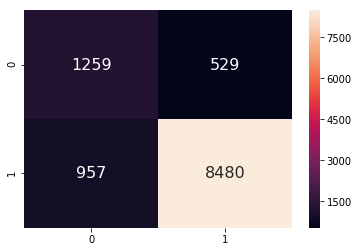

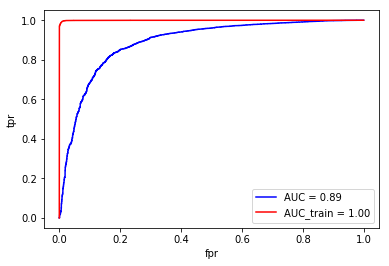

25299
The top ten positive features are-
 great        0.178605
love         0.137985
best         0.124148
good         0.122803
loves        0.093239
delicious    0.091144
excellent    0.083276
favorite     0.082350
nice         0.079987
perfect      0.079251
Name: 0, dtype: float64
The top ten negative features are-
 not             -0.142656
disappointed    -0.101235
worst           -0.070600
terrible        -0.067936
thought         -0.067376
horrible        -0.067289
disappointing   -0.067145
ok              -0.062978
weak            -0.057784
unfortunately   -0.057647
Name: 0, dtype: float64


In [47]:
model_new=SGDClassifier(class_weight='balanced',loss='hinge',penalty='l2',alpha=0.1)
model_new.fit(final_counts,y_tr)
pred=model_new.predict(X_test_bow)
acc=accuracy_score(y_test,pred,normalize=True)*float(100)
print("The accuracy of the model is =%d"%acc)
clf_sigmoid=CalibratedClassifierCV(model_new,cv=10,method='sigmoid')
clf_sigmoid.fit(final_counts,y_tr)
prob=clf_sigmoid.predict_proba(X_test_bow)[:,1]
fpr,tpr,thresholds=roc_curve(y_test,prob)
auc=roc_auc_score(y_test,prob)
prob1=clf_sigmoid.predict_proba(final_counts)[:,1]
fpr_train,tpr_train,thresholds=roc_curve(y_tr,prob1)
auc2=roc_auc_score(y_tr,prob1)
df_cm = pd.DataFrame(confusion_matrix(y_test, pred), range(2),range(2))
    #heatman for visualization of matrix
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')
plt.show()
plt.plot(fpr,tpr,'b', label = 'AUC = %0.2f' %auc)
plt.plot(fpr_train,tpr_train,'r', label = 'AUC_train = %0.2f' %auc2)
plt.legend(loc='lower right')
plt.xlabel('fpr')
plt.ylabel('tpr')
plt.show()
w=model_new.coef_
bow=count_vect.get_feature_names()
print(len(bow))
df=pd.DataFrame(w,columns=bow)
df=df.T
#df=df[0].sort_values(ascending=False)

#print(df.head(10))
print('The top ten positive features are-\n',df[0].sort_values(ascending=False)[0:10])
print('The top ten negative features are-\n',df[0].sort_values(ascending=True)[0:10])

### [5.1.2] Applying Linear SVM on TFIDF,<font color='red'> SET 2</font>

In [48]:
# Please write all the code with proper documentation
tuned_parameter=[{'alpha':[10**-4,10**-3,10**-2,10**-1,1,10,100,1000,10000]}]
model=GridSearchCV(SGDClassifier(),tuned_parameter,scoring='roc_auc',cv=10)
model.fit(final_tf_idf,y_tr)
print(model.best_estimator_)
print(model.score(X_cv_tfidf,y_cv))

SGDClassifier(alpha=1, average=False, class_weight=None, early_stopping=False,
              epsilon=0.1, eta0=0.0, fit_intercept=True, l1_ratio=0.15,
              learning_rate='optimal', loss='hinge', max_iter=1000,
              n_iter_no_change=5, n_jobs=None, penalty='l2', power_t=0.5,
              random_state=None, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)
0.932930026616775


The accuracy of the model is =89


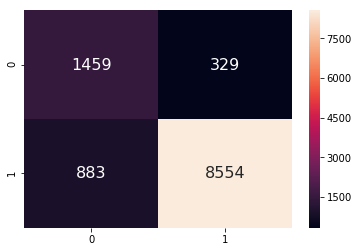

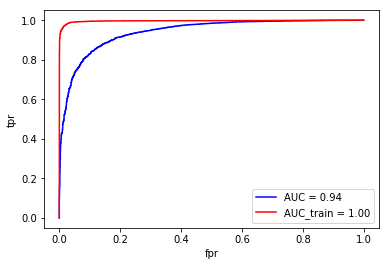

10971
The top ten positive features are-
 great        0.057681
love         0.047789
good         0.045031
best         0.041013
delicious    0.036070
loves        0.032841
nice         0.028522
favorite     0.028435
perfect      0.027501
excellent    0.025684
Name: 0, dtype: float64
The top ten negative features are-
 disappointed    -0.039210
worst           -0.035148
not             -0.033992
not worth       -0.033030
disappointing   -0.032885
not recommend   -0.031896
terrible        -0.031041
not good        -0.030294
not purchase    -0.030123
horrible        -0.026707
Name: 0, dtype: float64


In [49]:
model_new=SGDClassifier(class_weight='balanced',loss='hinge',penalty='l2',alpha=1)
model_new.fit(final_tf_idf,y_tr)
pred=model_new.predict(X_test_tfidf)
acc=accuracy_score(y_test,pred,normalize=True)*float(100)
print("The accuracy of the model is =%d"%acc)
clf_sigmoid=CalibratedClassifierCV(model_new,cv=10,method='sigmoid')
clf_sigmoid.fit(final_tf_idf,y_tr)
prob=clf_sigmoid.predict_proba(X_test_tfidf)[:,1]
fpr,tpr,thresholds=roc_curve(y_test,prob)
auc=roc_auc_score(y_test,prob)
prob1=clf_sigmoid.predict_proba(final_tf_idf)[:,1]
fpr_train,tpr_train,thresholds=roc_curve(y_tr,prob1)
auc2=roc_auc_score(y_tr,prob1)
df_cm = pd.DataFrame(confusion_matrix(y_test, pred), range(2),range(2))
    #heatman for visualization of matrix
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')
plt.show()
plt.plot(fpr,tpr,'b', label = 'AUC = %0.2f' %auc)
plt.plot(fpr_train,tpr_train,'r', label = 'AUC_train = %0.2f' %auc2)
plt.legend(loc='lower right')
plt.xlabel('fpr')
plt.ylabel('tpr')
plt.show()
w=model_new.coef_
tfidf=tf_idf_vect.get_feature_names()
print(len(tfidf))
df=pd.DataFrame(w,columns=tfidf)
df=df.T
#df=df[0].sort_values(ascending=False)

#print(df.head(10))
print('The top ten positive features are-\n',df[0].sort_values(ascending=False)[0:10])
print('The top ten negative features are-\n',df[0].sort_values(ascending=True)[0:10])

### [5.1.3]  Applying Linear SVM on AVG W2V,<font color='red'> SET 3</font>

In [50]:
# Please write all the code with proper documentation
# Please write all the code with proper documentation
tuned_parameter=[{'alpha':[10**-4,10**-3,10**-2,10**-1,1,10,100,1000,10000]}]
model=GridSearchCV(SGDClassifier(),tuned_parameter,scoring='roc_auc',cv=10)
model.fit(sent_vectors_train,y_tr)
print(model.best_estimator_)
ideal_alpha=model.best_estimator_.alpha
print(model.score(sent_vectors_cv,y_cv))

SGDClassifier(alpha=0.01, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=None, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)
0.875623499296069


The accuracy of the model is =74


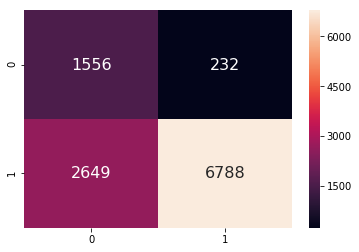

Text(0,0.5,'tpr')

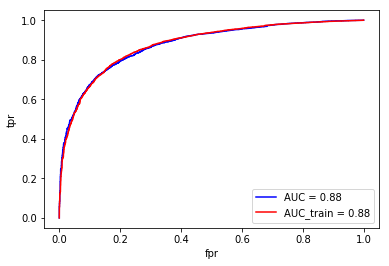

In [51]:
model_new=SGDClassifier(class_weight='balanced',loss='hinge',penalty='l2',alpha=ideal_alpha)
model_new.fit(sent_vectors_train,y_tr)
pred=model_new.predict(sent_vectors_test)
acc=accuracy_score(y_test,pred,normalize=True)*float(100)
print("The accuracy of the model is =%d"%acc)
clf_sigmoid=CalibratedClassifierCV(model_new,cv=10,method='sigmoid')
clf_sigmoid.fit(sent_vectors_train,y_tr)
prob=clf_sigmoid.predict_proba(sent_vectors_test)[:,1]
fpr,tpr,thresholds=roc_curve(y_test,prob)
auc=roc_auc_score(y_test,prob)
prob1=clf_sigmoid.predict_proba(sent_vectors_train)[:,1]
fpr_train,tpr_train,thresholds=roc_curve(y_tr,prob1)
auc2=roc_auc_score(y_tr,prob1)
df_cm = pd.DataFrame(confusion_matrix(y_test, pred), range(2),range(2))
    #heatman for visualization of matrix
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')
plt.show()
plt.plot(fpr,tpr,'b', label = 'AUC = %0.2f' %auc)
plt.plot(fpr_train,tpr_train,'r', label = 'AUC_train = %0.2f' %auc2)
plt.legend(loc='lower right')
plt.xlabel('fpr')
plt.ylabel('tpr')

### [5.1.4]  Applying Linear SVM on TFIDF W2V,<font color='red'> SET 4</font>

In [52]:
# Please write all the code with proper documentation
tuned_parameter=[{'alpha':[10**-4,10**-3,10**-2,10**-1,1,10,100,1000,10000]}]
model=GridSearchCV(SGDClassifier(),tuned_parameter,scoring='roc_auc',cv=10)
model.fit(tfidf_sent_vectors_train,y_tr)
print(model.best_estimator_)
ideal_alpha=model.best_estimator_.alpha
print(model.score(tfidf_sent_vectors_cv,y_cv))

SGDClassifier(alpha=0.1, average=False, class_weight=None, early_stopping=False,
              epsilon=0.1, eta0=0.0, fit_intercept=True, l1_ratio=0.15,
              learning_rate='optimal', loss='hinge', max_iter=1000,
              n_iter_no_change=5, n_jobs=None, penalty='l2', power_t=0.5,
              random_state=None, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)
0.5048129729336692


The accuracy of the model is =83


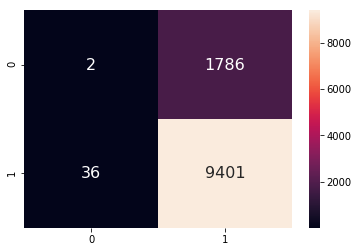

Text(0,0.5,'tpr')

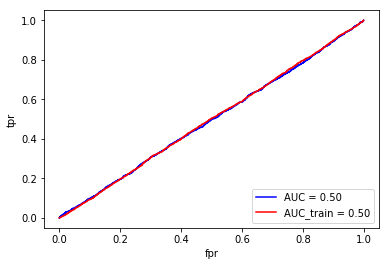

In [53]:
model_new=SGDClassifier(class_weight='balanced',loss='hinge',penalty='l2',alpha=ideal_alpha)
model_new.fit(tfidf_sent_vectors_train,y_tr)
pred=model_new.predict(tfidf_sent_vectors_test)
acc=accuracy_score(y_test,pred,normalize=True)*float(100)
print("The accuracy of the model is =%d"%acc)
clf_sigmoid=CalibratedClassifierCV(model_new,cv=10,method='sigmoid')
clf_sigmoid.fit(tfidf_sent_vectors_train,y_tr)
prob=clf_sigmoid.predict_proba(tfidf_sent_vectors_test)[:,1]
fpr,tpr,thresholds=roc_curve(y_test,prob)
auc=roc_auc_score(y_test,prob)
prob1=clf_sigmoid.predict_proba(tfidf_sent_vectors_train)[:,1]
fpr_train,tpr_train,thresholds=roc_curve(y_tr,prob1)
auc2=roc_auc_score(y_tr,prob1)
df_cm = pd.DataFrame(confusion_matrix(y_test, pred), range(2),range(2))
    #heatman for visualization of matrix
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')
plt.show()
plt.plot(fpr,tpr,'b', label = 'AUC = %0.2f' %auc)
plt.plot(fpr_train,tpr_train,'r', label = 'AUC_train = %0.2f' %auc2)
plt.legend(loc='lower right')
plt.xlabel('fpr')
plt.ylabel('tpr')

## [5.2] RBF SVM

### [5.2.1] Applying RBF SVM on BOW,<font color='red'> SET 1</font>

In [54]:
# Please write all the code with proper documentation
count_vect = CountVectorizer(min_df=10, max_features=50) 
count_vect.fit(X_tr)

print("some feature names ", count_vect.get_feature_names()[:10])
print('='*50)

final_counts = count_vect.transform(X_tr)
final_counts=scaler.fit_transform(final_counts)
X_cv_bow=count_vect.transform(X_cv)
X_cv_bow=scaler.fit_transform(X_cv_bow)
X_test_bow=count_vect.transform(X_test)
X_test_bow=scaler.fit_transform(X_test_bow)
print("the type of count vectorizer ",type(final_counts))
print("the shape of out text BOW vectorizer ",final_counts.get_shape())
print("the number of unique words ", final_counts.get_shape()[1])
print(y_test.shape)

some feature names  ['also', 'amazon', 'bag', 'best', 'better', 'bought', 'buy', 'chocolate', 'coffee', 'could']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (18333, 50)
the number of unique words  50
(11225,)


In [55]:
from sklearn.svm import SVC
tuned_parameter=[{'C':[10**-4,10**-3,10**-2,10**-1,1,10,100,1000,10000]}]
model=GridSearchCV(SVC(),tuned_parameter,scoring='roc_auc',cv=10)
model.fit(final_counts,y_tr)
print(model.best_estimator_)
ideal_c=model.best_estimator_.C
print(model.score(X_cv_bow,y_cv))

SVC(C=0.1, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='rbf', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)
0.7434447947203654


The accuracy of the model is =63


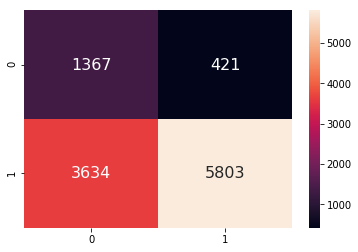

Text(0,0.5,'tpr')

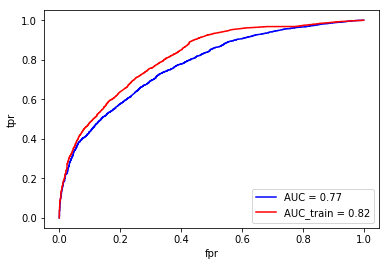

In [56]:
model_new=SVC(C=ideal_c,kernel='rbf',probability=True,class_weight='balanced')
model_new.fit(final_counts,y_tr)
pred=model_new.predict(X_test_bow)
acc=accuracy_score(y_test,pred,normalize=True)*float(100)
print("The accuracy of the model is =%d"%acc)
probab=model_new.predict_proba(X_test_bow)[:,1]
fpr,tpr,thresholds=roc_curve(y_test,probab)
auc=roc_auc_score(y_test,probab)
pred2=model_new.predict(final_counts)
probab2=model_new.predict_proba(final_counts)[:,1]
fpr_train,tpr_train,thresholds=roc_curve(y_tr,probab2)
auc2=roc_auc_score(y_tr,probab2)
df_cm = pd.DataFrame(confusion_matrix(y_test, pred), range(2),range(2))
    #heatman for visualization of matrix
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')
plt.show()
plt.plot(fpr,tpr,'b', label = 'AUC = %0.2f' %auc)
plt.plot(fpr_train,tpr_train,'r', label = 'AUC_train = %0.2f' %auc2)
plt.legend(loc='lower right')
plt.xlabel('fpr')
plt.ylabel('tpr')

### [5.2.2] Applying RBF SVM on TFIDF,<font color='red'> SET 2</font>

In [57]:
# Please write all the code with proper documentation
# Please write all the code with proper documentation
count_vect_gram = CountVectorizer(ngram_range=(1,2), min_df=10, max_features=50)
count_vect_gram.fit(X_tr)
final_bigram_counts = count_vect_gram.transform(X_tr)
final_bigram_counts=scaler.fit_transform(final_bigram_counts)
X_cv_ngram = count_vect_gram.transform(X_cv)
X_cv_ngram=scaler.fit_transform(X_cv_ngram)
X_test_ngram=count_vect_gram.transform(X_test)
X_test_ngram=scaler.fit_transform(X_test_ngram)
print("the type of count vectorizer ",type(final_bigram_counts))
print("the shape of out text BOW vectorizer ",final_bigram_counts.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_bigram_counts.get_shape()[1])

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (18333, 50)
the number of unique words including both unigrams and bigrams  50


In [58]:
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2), min_df=10,max_features=500)
tf_idf_vect.fit(X_tr)

print("some sample features(unique words in the corpus)",tf_idf_vect.get_feature_names()[0:10])
print('='*50)

final_tf_idf = tf_idf_vect.transform(X_tr)
final_tf_idf=scaler.fit_transform(final_tf_idf)
X_cv_tfidf=tf_idf_vect.transform(X_cv)
X_cv_tfidf=scaler.fit_transform(X_cv_tfidf)
X_test_tfidf=tf_idf_vect.transform(X_test)
X_test_tfidf=scaler.fit_transform(X_test_tfidf)
print("the type of count vectorizer ",type(final_tf_idf))
print("the shape of out text TFIDF vectorizer ",final_tf_idf.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_tf_idf.get_shape()[1])

some sample features(unique words in the corpus) ['able', 'absolutely', 'acid', 'actually', 'add', 'added', 'aftertaste', 'ago', 'almost', 'also']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text TFIDF vectorizer  (18333, 500)
the number of unique words including both unigrams and bigrams  500


In [59]:
tuned_parameter=[{'C':[10**-4,10**-3,10**-2,10**-1,1,10,100,1000,10000]}]
model=GridSearchCV(SVC(),tuned_parameter,scoring='roc_auc',cv=10)
model.fit(final_tf_idf,y_tr)
print(model.best_estimator_)
ideal_c=model.best_estimator_.C
print(model.score(X_cv_tfidf,y_cv))

SVC(C=10, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='rbf', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)
0.9029224151652927


The accuracy of the model is =88


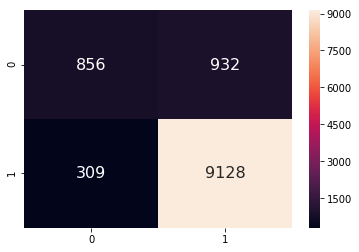

Text(0,0.5,'tpr')

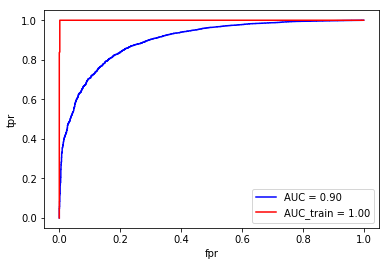

In [60]:
model_new=SVC(C=ideal_c,kernel='rbf',probability=True,class_weight='balanced')
model_new.fit(final_tf_idf,y_tr)
pred=model_new.predict(X_test_tfidf)
acc=accuracy_score(y_test,pred,normalize=True)*float(100)
print("The accuracy of the model is =%d"%acc)
probab=model_new.predict_proba(X_test_tfidf)[:,1]
fpr,tpr,thresholds=roc_curve(y_test,probab)
auc=roc_auc_score(y_test,probab)
pred2=model_new.predict(final_tf_idf)
probab2=model_new.predict_proba(final_tf_idf)[:,1]
fpr_train,tpr_train,thresholds=roc_curve(y_tr,probab2)
auc2=roc_auc_score(y_tr,probab2)
df_cm = pd.DataFrame(confusion_matrix(y_test, pred), range(2),range(2))
    #heatman for visualization of matrix
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')
plt.show()
plt.plot(fpr,tpr,'b', label = 'AUC = %0.2f' %auc)
plt.plot(fpr_train,tpr_train,'r', label = 'AUC_train = %0.2f' %auc2)
plt.legend(loc='lower right')
plt.xlabel('fpr')
plt.ylabel('tpr')

### [5.2.3]  Applying RBF SVM on AVG W2V,<font color='red'> SET 3</font>

In [50]:
# Please write all the code with proper documentation
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
tuned_parameter=[{'C':[10**-4,10**-3,10**-2,10**-1,1,10,100,1000,10000]}]
model=GridSearchCV(SVC(),tuned_parameter,scoring='roc_auc',cv=10)
model.fit(sent_vectors_train,y_tr)
print(model.best_estimator_)
ideal_c=model.best_estimator_.C
print(model.score(sent_vectors_cv,y_cv))

SVC(C=1, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='rbf', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)
0.8804138182789811


The accuracy of the model is =80


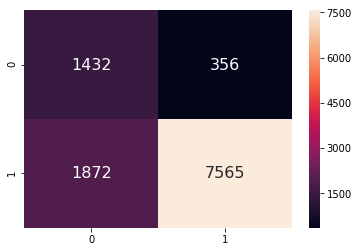

Text(0,0.5,'tpr')

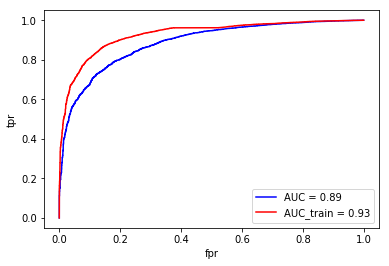

In [51]:
model_new=SVC(C=ideal_c,kernel='rbf',probability=True,class_weight='balanced')
model_new.fit(sent_vectors_train,y_tr)
pred=model_new.predict(sent_vectors_test)
acc=accuracy_score(y_test,pred,normalize=True)*float(100)
print("The accuracy of the model is =%d"%acc)
probab=model_new.predict_proba(sent_vectors_test)[:,1]
fpr,tpr,thresholds=roc_curve(y_test,probab)
auc=roc_auc_score(y_test,probab)
pred2=model_new.predict(sent_vectors_train)
probab2=model_new.predict_proba(sent_vectors_train)[:,1]
fpr_train,tpr_train,thresholds=roc_curve(y_tr,probab2)
auc2=roc_auc_score(y_tr,probab2)
df_cm = pd.DataFrame(confusion_matrix(y_test, pred), range(2),range(2))
    #heatman for visualization of matrix
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')
plt.show()
plt.plot(fpr,tpr,'b', label = 'AUC = %0.2f' %auc)
plt.plot(fpr_train,tpr_train,'r', label = 'AUC_train = %0.2f' %auc2)
plt.legend(loc='lower right')
plt.xlabel('fpr')
plt.ylabel('tpr')

### [5.2.4]  Applying RBF SVM on TFIDF W2V,<font color='red'> SET 4</font>

In [ ]:
'''# Please write all the code with proper documentation
# S = ["abc def pqr", "def def def abc", "pqr pqr def"]
model_train= TfidfVectorizer(ngram_range=(1,2), min_df=10, max_features=50)
tf_idf_matrix_train = model_train.fit_transform(X_tr)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary_train = dict(zip(model_train.get_feature_names(), list(model_train.idf_)))'''

In [ ]:
# S = ["abc def pqr", "def def def abc", "pqr pqr def"]
''''model_cv= TfidfVectorizer(ngram_range=(1,2), min_df=10, max_features=50)
tf_idf_matrix_cv = model_cv.fit_transform(X_cv)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary_cv= dict(zip(model_cv.get_feature_names(), list(model_cv.idf_)))'''

In [ ]:
'''# TF-IDF weighted Word2Vec
tfidf_feat_train = model_train.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors_train = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentance_train): # for each review/sentence 
    sent_vec_train = np.zeros(50) # as word vectors are of zero length
    weight_sum_train =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words_train and word in tfidf_feat_train:
            vec_train = w2v_model_train.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf= dictionary_train[word]*(sent.count(word)/len(sent))
            sent_vec_train += (vec * tf_idf)
            weight_sum_train += tf_idf
    if weight_sum_train != 0:
        sent_vec_train /= weight_sum_train
    tfidf_sent_vectors_train.append(sent_vec_train)
    row += 1
tfidf_sent_vectors_train =scaler.fit_transform(tfidf_sent_vectors_train)'''

In [ ]:
'''tfidf_feat_cv = model_cv.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors_cv = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentance_cv): # for each review/sentence 
    sent_vec_cv = np.zeros(50) # as word vectors are of zero length
    weight_sum_cv =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words_train and word in tfidf_feat_cv:
            vec_cv = w2v_model_train.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary_train[word]*(sent.count(word)/len(sent))
            sent_vec_cv += (vec * tf_idf)
            weight_sum_cv += tf_idf
    if weight_sum_cv != 0:
        sent_vec_cv /= weight_sum_cv
    tfidf_sent_vectors_cv.append(sent_vec_cv)
    row += 1
tfidf_sent_vectors_cv =scaler.fit_transform(tfidf_sent_vectors_cv)'''

In [ ]:
'''tfidf_feat_test = model_test.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors_test = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentance_test): # for each review/sentence 
    sent_vec_test = np.zeros(50) # as word vectors are of zero length
    weight_sum_test =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words_train and word in tfidf_feat_test:
            vec_test = w2v_model_train.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary_train[word]*(sent.count(word)/len(sent))
            sent_vec_test += (vec * tf_idf)
            weight_sum_test += tf_idf
    if weight_sum_test != 0:
        sent_vec_test /= weight_sum_test
    tfidf_sent_vectors_test.append(sent_vec_test)
    row += 1
tfidf_sent_vectors_test =scaler.fit_transform(tfidf_sent_vectors_test)'''

In [52]:
# Please write all the code with proper documentation
tuned_parameter=[{'C':[10**-4,10**-3,10**-2,10**-1,1,10,100,1000,10000]}]
model=GridSearchCV(SVC(),tuned_parameter,scoring='roc_auc',cv=10)
model.fit(tfidf_sent_vectors_train,y_tr)
print(model.best_estimator_)
ideal_c=model.best_estimator_.C
print(model.score(tfidf_sent_vectors_cv,y_cv))

SVC(C=10, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='rbf', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)
0.500462363178603


The accuracy of the model is =16


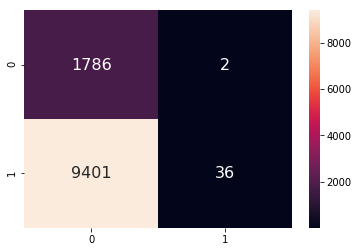

Text(0,0.5,'tpr')

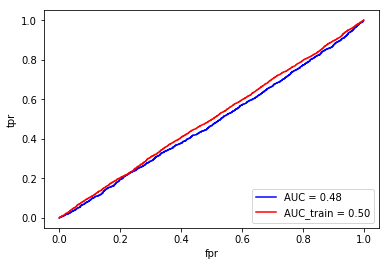

In [53]:
model_new=SVC(C=ideal_c,kernel='rbf',probability=True,class_weight='balanced')
model_new.fit(tfidf_sent_vectors_train,y_tr)
pred=model_new.predict(tfidf_sent_vectors_test)
acc=accuracy_score(y_test,pred,normalize=True)*float(100)
print("The accuracy of the model is =%d"%acc)
probab=model_new.predict_proba(tfidf_sent_vectors_test)[:,1]
fpr,tpr,thresholds=roc_curve(y_test,probab)
auc=roc_auc_score(y_test,probab)
pred2=model_new.predict(tfidf_sent_vectors_train)
probab2=model_new.predict_proba(tfidf_sent_vectors_train)[:,1]
fpr_train,tpr_train,thresholds=roc_curve(y_tr,probab2)
auc2=roc_auc_score(y_tr,probab2)
df_cm = pd.DataFrame(confusion_matrix(y_test, pred), range(2),range(2))
    #heatman for visualization of matrix
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')
plt.show()
plt.plot(fpr,tpr,'b', label = 'AUC = %0.2f' %auc)
plt.plot(fpr_train,tpr_train,'r', label = 'AUC_train = %0.2f' %auc2)
plt.legend(loc='lower right')
plt.xlabel('fpr')
plt.ylabel('tpr')

# [6] Conclusions

In [54]:
# Please compare all your models using Prettytable library
from prettytable import PrettyTable
x=PrettyTable()
x.field_names=(['Vectorizer','Kernel','Hyperparameter-C','AUC'])
x.add_row(['BOW','Linear',0.1,0.90])
x.add_row(['TFIDF','linear',1,0.94])
x.add_row(['Avg W2V','Linear',0.01,0.88])
x.add_row(['Weighted TFIDF','Linear',0.01,0.49])
x.add_row(['BOW','RBF SVM',0.1,0.78])
x.add_row(['TFIDF','RBF SVM',0.1,0.39])
x.add_row(['Avg W2V','Linear',1,0.89])
x.add_row(['Weighted TFIDF','RBF SVM',10,0.48])
print(x)    

+----------------+---------+------------------+------+
|   Vectorizer   |  Kernel | Hyperparameter-C | AUC  |
+----------------+---------+------------------+------+
|      BOW       |  Linear |       0.1        | 0.9  |
|     TFIDF      |  linear |        1         | 0.94 |
|    Avg W2V     |  Linear |       0.01       | 0.88 |
| Weighted TFIDF |  Linear |       0.01       | 0.49 |
|      BOW       | RBF SVM |       0.1        | 0.78 |
|     TFIDF      | RBF SVM |       0.1        | 0.39 |
|    Avg W2V     |  Linear |        1         | 0.89 |
| Weighted TFIDF | RBF SVM |        10        | 0.48 |
+----------------+---------+------------------+------+
